<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Train/Test-Split" data-toc-modified-id="Train/Test-Split-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Train/Test Split</a></span><ul class="toc-item"><li><span><a href="#SPY" data-toc-modified-id="SPY-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>SPY</a></span></li><li><span><a href="#TNX" data-toc-modified-id="TNX-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>TNX</a></span></li><li><span><a href="#VIX" data-toc-modified-id="VIX-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>VIX</a></span></li></ul></li><li><span><a href="#Preparation-for-Convolutional-Neural-Network" data-toc-modified-id="Preparation-for-Convolutional-Neural-Network-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Preparation for Convolutional Neural Network</a></span></li></ul></div>

# Fit the model

We select three indexes to sketch the effect of the FOMC's documents on the market: S&P 500 Index(SPY), Treasury Yield 10 Years (TNX), CBOE Volatility Index (VIX). The data is from [Yahoo Finance](https://finance.yahoo.com/)

In [1]:
import datetime
import keras
import numpy as np
import pandas as pd

from gensim.models import KeyedVectors, Doc2Vec
from gensim.models.word2vec import Word2Vec
from gensim.models.doc2vec import TaggedDocument
from gensim.models.phrases import Phrases
from gensim.models.phrases import Phraser
from keras.callbacks import ModelCheckpoint
from keras.layers import Input, Dense, concatenate, Activation, Dropout, Flatten, Conv1D, GlobalMaxPooling1D
from keras.layers.embeddings import Embedding
from keras.models import Model, Sequential, load_model
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
import matplotlib.pyplot as plt
from sklearn import utils
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Normalizer, scale
from textblob import TextBlob
from time import time
from tqdm import tqdm 

In [2]:
spy_df = pd.read_csv('./data/SPY.csv')
spy_df.fillna(method='pad')
spy_df["SPY"] = spy_df["Adj Close"].pct_change() * 100
spy_df.drop(columns=["Open", 'High', 'Low', 'Close', "Adj Close", 'Volume'], inplace=True)
spy_df.drop(0, inplace=True)
vix_df = pd.read_csv('./data/^VIX.csv')
vix_df.fillna(method='pad')
vix_df["VIX"] = vix_df["Adj Close"].pct_change() * 100
vix_df.drop(columns=["Open", 'High', 'Low', 'Close', "Adj Close", 'Volume'], inplace=True)
vix_df.drop(0, inplace=True)
tnx_df = pd.read_csv('./data/^TNX.csv')
tnx_df.fillna(method='pad')
tnx_df["TNX"] = tnx_df["Adj Close"].pct_change() * 100
tnx_df.drop(columns=["Open", 'High', 'Low', 'Close', "Adj Close", 'Volume'], inplace=True)
tnx_df.drop(0, inplace=True)

In [3]:
mkt_df = pd.merge(spy_df, vix_df, how='left', on='Date')
mkt_df = pd.merge(mkt_df, tnx_df, how='left', on='Date')
mkt_df.rename(columns={'Date': 'date'}, inplace=True)
mkt_df['date'] = pd.to_datetime(mkt_df['date'])

In [4]:
data_1 = pd.read_feather("./data_1.feather")
data_2 = pd.read_feather("./data_2.feather")
data_2 = pd.concat([data_2['minutes'], data_1['date']], axis=1)

In [5]:
df_statements = pd.merge(data_1, mkt_df, how='left', on='date')
mkt_df['date'] = mkt_df['date'] - datetime.timedelta(days=21)
df_minutes = pd.merge(data_2, mkt_df, how='left', on='date')

In [6]:
for var in df_minutes.columns[-3:]:
    df_minutes[var] = df_minutes[var].apply(lambda x: 1 if x > 0 else 0)

## Train/Test Split

The ratio I decided to split my data is 80/20, 80% of data as the training set, and the rest 20% for the test set. Intuitively the minutes have more information than the statements, so all following experiments are based on the minutes.

### SPY

In [7]:
x = df_minutes['minutes']
y = df_minutes['SPY']

In [8]:
SEED = 2000
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.2, random_state=SEED)

In [9]:
print("Train set has total {0} entries with {1:.2f}% negative, {2:.2f}% positive".format(
    len(x_train), (len(x_train[y_train == 0]) / (len(x_train) * 1.)) * 100, (
            len(x_train[y_train == 1]) / (len(x_train) * 1.)) * 100))
print("Test set has total {0} entries with {1:.2f}% negative, {2:.2f}% positive".format(
    len(x_test), (len(x_test[y_test == 0]) / (len(x_test) * 1.)) * 100, (
            len(x_test[y_test == 1]) / (len(x_test) * 1.)) * 100))

Train set has total 153 entries with 49.02% negative, 50.98% positive
Test set has total 39 entries with 38.46% negative, 61.54% positive


### TNX

In [10]:
x = df_minutes['minutes']
y = df_minutes['TNX']

In [11]:
SEED = 2000
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.2, random_state=SEED)

In [12]:
print("Train set has total {0} entries with {1:.2f}% negative, {2:.2f}% positive".format(
    len(x_train), (len(x_train[y_train == 0]) / (len(x_train) * 1.)) * 100, (
            len(x_train[y_train == 1]) / (len(x_train) * 1.)) * 100))
print("Test set has total {0} entries with {1:.2f}% negative, {2:.2f}% positive".format(
    len(x_test), (len(x_test[y_test == 0]) / (len(x_test) * 1.)) * 100, (
            len(x_test[y_test == 1]) / (len(x_test) * 1.)) * 100))

Train set has total 153 entries with 49.02% negative, 50.98% positive
Test set has total 39 entries with 38.46% negative, 61.54% positive


### VIX

In [13]:
x = df_minutes['minutes']
y = df_minutes['VIX']

In [14]:
SEED = 2000
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.2, random_state=SEED)

In [15]:
print("Train set has total {0} entries with {1:.2f}% negative, {2:.2f}% positive".format(
    len(x_train), (len(x_train[y_train == 0]) / (len(x_train) * 1.)) * 100, (
            len(x_train[y_train == 1]) / (len(x_train) * 1.)) * 100))
print("Test set has total {0} entries with {1:.2f}% negative, {2:.2f}% positive".format(
    len(x_test), (len(x_test[y_test == 0]) / (len(x_test) * 1.)) * 100, (
            len(x_test[y_test == 1]) / (len(x_test) * 1.)) * 100))

Train set has total 153 entries with 60.13% negative, 39.87% positive
Test set has total 39 entries with 58.97% negative, 41.03% positive


## Preparation for Convolutional Neural Network

In [16]:
x = df_statements['statements']
# y = df_minutes['TNX']
# y = df_statements['SPY']
y = df_minutes['VIX']

# x = df_minutes['minutes']
# y = df_minutes['TNX']
# y = df_minutes['SPY']
# y = df_minutes['VIX']
SEED = 2000
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.2, random_state=SEED)

In [17]:
def labelize_ug(tweets,label):
    result = []
    prefix = label
    for i, t in zip(tweets.index, tweets):
        result.append(TaggedDocument(t.split(), [prefix + '_%s' % i]))
    return result

In [18]:
all_x_w2v = labelize_ug(x, 'all')

In [19]:
model_ug_cbow = Word2Vec(sg=0, negative=5, window=2, min_count=2, workers=16, alpha=0.065, min_alpha=0.065)
model_ug_cbow.build_vocab([x.words for x in tqdm(all_x_w2v)])

100%|████████████████████████████████████████████████████████████████████████████████████████| 192/192 [00:00<?, ?it/s]


In [20]:
%%time
for epoch in range(30):
    model_ug_cbow.train(utils.shuffle([x.words for x in tqdm(all_x_w2v)]), total_examples=len(all_x_w2v), epochs=1)
    model_ug_cbow.alpha -= 0.002
    model_ug_cbow.min_alpha = model_ug_cbow.alpha

100%|████████████████████████████████████████████████████████████████████████████████████████| 192/192 [00:00<?, ?it/s]

Wall time: 783 ms


In [21]:
model_ug_sg = Word2Vec(sg=1, negative=5, window=2, min_count=2, workers=16, alpha=0.065, min_alpha=0.065)
model_ug_sg.build_vocab([x.words for x in tqdm(all_x_w2v)])

100%|████████████████████████████████████████████████████████████████████████████████████████| 192/192 [00:00<?, ?it/s]


In [22]:
%%time
for epoch in range(30):
    model_ug_sg.train(utils.shuffle([x.words for x in tqdm(all_x_w2v)]), total_examples=len(all_x_w2v), epochs=1)
    model_ug_sg.alpha -= 0.002
    model_ug_sg.min_alpha = model_ug_sg.alpha

100%|████████████████████████████████████████████████████████████████████████████████████████| 192/192 [00:00<?, ?it/s]

Wall time: 1.02 s


In [23]:
model_ug_cbow.save('w2v_model_ug_cbow.word2vec')
model_ug_sg.save('w2v_model_ug_sg.word2vec')

In [24]:
model_ug_cbow = KeyedVectors.load('w2v_model_ug_cbow.word2vec')
model_ug_sg = KeyedVectors.load('w2v_model_ug_sg.word2vec')

In [25]:
len(model_ug_cbow.wv.index_to_key)

1158

In [26]:
embeddings_index = {}
for w in model_ug_cbow.wv.index_to_key:
    embeddings_index[w] = np.append(model_ug_cbow.wv[w],model_ug_sg.wv[w])
print('Found %s word vectors.' % len(embeddings_index))

Found 1158 word vectors.


In [27]:
tokenizer = Tokenizer(num_words=100000)
tokenizer.fit_on_texts(x_train)
sequences = tokenizer.texts_to_sequences(x_train)

In [28]:
len(tokenizer.word_index)

1475

In [29]:
length = []
for x in x_train:
    length.append(len(x.split()))

In [30]:
x_train_seq = pad_sequences(sequences, maxlen=len(length)+10)
print('Shape of data tensor:', x_train_seq.shape)

Shape of data tensor: (153, 163)


In [31]:
sequences_val = tokenizer.texts_to_sequences(x_test)
x_test_seq = pad_sequences(sequences_val, maxlen=len(length)+10)

In [32]:
num_words = 100000
embedding_matrix = np.zeros((num_words, 200))
for word, i in tokenizer.word_index.items():
    if i >= num_words:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [33]:
model_ptw2v = Sequential()
e = Embedding(100000, 200, weights=[embedding_matrix], input_length=len(length)+10, trainable=False)
model_ptw2v.add(e)
model_ptw2v.add(Flatten())
model_ptw2v.add(Dense(256, activation='relu'))
model_ptw2v.add(Dense(1, activation='sigmoid'))
model_ptw2v.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_ptw2v.fit(x_train_seq, y_train, validation_data=(x_test_seq ,y_test), epochs=5, batch_size=32, verbose=2)

Epoch 1/5
5/5 - 1s - loss: 3.5779 - accuracy: 0.5033 - val_loss: 2.8014 - val_accuracy: 0.5385 - 562ms/epoch - 112ms/step
Epoch 2/5
5/5 - 0s - loss: 1.0778 - accuracy: 0.8039 - val_loss: 2.1497 - val_accuracy: 0.4872 - 139ms/epoch - 28ms/step
Epoch 3/5
5/5 - 0s - loss: 0.7380 - accuracy: 0.9150 - val_loss: 1.7983 - val_accuracy: 0.5128 - 141ms/epoch - 28ms/step
Epoch 4/5
5/5 - 0s - loss: 0.3346 - accuracy: 0.9477 - val_loss: 1.8168 - val_accuracy: 0.5128 - 165ms/epoch - 33ms/step
Epoch 5/5
5/5 - 0s - loss: 0.3287 - accuracy: 0.9477 - val_loss: 1.6898 - val_accuracy: 0.5128 - 140ms/epoch - 28ms/step


In [34]:
model_ptw2v = Sequential()
e = Embedding(100000, 200, input_length=len(length)+10)
model_ptw2v.add(e)
model_ptw2v.add(Flatten())
model_ptw2v.add(Dense(256, activation='relu'))
model_ptw2v.add(Dense(1, activation='sigmoid'))
model_ptw2v.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_ptw2v.fit(x_train_seq, y_train, validation_data=(x_test_seq ,y_test), epochs=5, batch_size=32, verbose=2)

Epoch 1/5
5/5 - 1s - loss: 0.7221 - accuracy: 0.5490 - val_loss: 0.7236 - val_accuracy: 0.6923 - 1s/epoch - 241ms/step
Epoch 2/5
5/5 - 1s - loss: 0.3627 - accuracy: 0.9150 - val_loss: 0.8744 - val_accuracy: 0.5385 - 888ms/epoch - 178ms/step
Epoch 3/5
5/5 - 1s - loss: 0.2150 - accuracy: 0.9412 - val_loss: 1.0141 - val_accuracy: 0.5641 - 873ms/epoch - 175ms/step
Epoch 4/5
5/5 - 1s - loss: 0.1341 - accuracy: 0.9477 - val_loss: 1.1179 - val_accuracy: 0.5641 - 862ms/epoch - 172ms/step
Epoch 5/5
5/5 - 1s - loss: 0.1010 - accuracy: 0.9477 - val_loss: 1.2495 - val_accuracy: 0.5641 - 977ms/epoch - 195ms/step


In [35]:
model_ptw2v = Sequential()
e = Embedding(100000, 200, weights=[embedding_matrix], input_length=len(length)+10, trainable=True)
model_ptw2v.add(e)
model_ptw2v.add(Flatten())
model_ptw2v.add(Dense(256, activation='relu'))
model_ptw2v.add(Dense(1, activation='sigmoid'))
model_ptw2v.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_ptw2v.fit(x_train_seq, y_train, validation_data=(x_test_seq ,y_test), epochs=5, batch_size=32, verbose=2)

Epoch 1/5
5/5 - 1s - loss: 4.3720 - accuracy: 0.4510 - val_loss: 3.7253 - val_accuracy: 0.5897 - 1s/epoch - 251ms/step
Epoch 2/5
5/5 - 1s - loss: 2.0764 - accuracy: 0.7190 - val_loss: 2.2914 - val_accuracy: 0.5128 - 944ms/epoch - 189ms/step
Epoch 3/5
5/5 - 1s - loss: 0.5515 - accuracy: 0.8758 - val_loss: 1.1386 - val_accuracy: 0.5897 - 893ms/epoch - 179ms/step
Epoch 4/5
5/5 - 1s - loss: 0.2607 - accuracy: 0.8954 - val_loss: 1.1688 - val_accuracy: 0.5385 - 885ms/epoch - 177ms/step
Epoch 5/5
5/5 - 1s - loss: 0.2006 - accuracy: 0.9412 - val_loss: 1.3657 - val_accuracy: 0.4872 - 853ms/epoch - 171ms/step


In [36]:
structure_test = Sequential()
e = Embedding(100000, 200, input_length=len(length)+10)
structure_test.add(e)
structure_test.add(Conv1D(filters=100, kernel_size=2, padding='valid', activation='relu', strides=1))
structure_test.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 163, 200)          20000000  
                                                                 
 conv1d (Conv1D)             (None, 162, 100)          40100     
                                                                 
Total params: 20,040,100
Trainable params: 20,040,100
Non-trainable params: 0
_________________________________________________________________


In [37]:
structure_test = Sequential()
e = Embedding(100000, 200, input_length=45)
structure_test.add(e)
structure_test.add(Conv1D(filters=100, kernel_size=2, padding='valid', activation='relu', strides=1))
structure_test.add(GlobalMaxPooling1D())
structure_test.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 45, 200)           20000000  
                                                                 
 conv1d_1 (Conv1D)           (None, 44, 100)           40100     
                                                                 
 global_max_pooling1d (Globa  (None, 100)              0         
 lMaxPooling1D)                                                  
                                                                 
Total params: 20,040,100
Trainable params: 20,040,100
Non-trainable params: 0
_________________________________________________________________


In [38]:
model_cnn_01 = Sequential()
e = Embedding(100000, 200, weights=[embedding_matrix], input_length=len(length)+10, trainable=False)
model_cnn_01.add(e)
model_cnn_01.add(Conv1D(filters=100, kernel_size=2, padding='valid', activation='relu', strides=1))
model_cnn_01.add(GlobalMaxPooling1D())
model_cnn_01.add(Dense(256, activation='relu'))
model_cnn_01.add(Dense(1, activation='sigmoid'))
model_cnn_01.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_cnn_01.fit(x_train_seq, y_train, validation_data=(x_test_seq, y_test), epochs=5, batch_size=32, verbose=2)

Epoch 1/5
5/5 - 0s - loss: 1.1550 - accuracy: 0.5425 - val_loss: 0.9371 - val_accuracy: 0.5897 - 494ms/epoch - 99ms/step
Epoch 2/5
5/5 - 0s - loss: 0.7348 - accuracy: 0.6013 - val_loss: 0.8361 - val_accuracy: 0.4872 - 67ms/epoch - 13ms/step
Epoch 3/5
5/5 - 0s - loss: 0.5875 - accuracy: 0.6732 - val_loss: 0.7978 - val_accuracy: 0.5897 - 68ms/epoch - 14ms/step
Epoch 4/5
5/5 - 0s - loss: 0.6461 - accuracy: 0.6209 - val_loss: 0.7283 - val_accuracy: 0.5641 - 66ms/epoch - 13ms/step
Epoch 5/5
5/5 - 0s - loss: 0.5889 - accuracy: 0.6209 - val_loss: 0.7629 - val_accuracy: 0.5128 - 66ms/epoch - 13ms/step


In [39]:
model_cnn_02 = Sequential()
e = Embedding(100000, 200, input_length=len(length)+10)
model_cnn_02.add(e)
model_cnn_02.add(Conv1D(filters=100, kernel_size=2, padding='valid', activation='relu', strides=1))
model_cnn_02.add(GlobalMaxPooling1D())
model_cnn_02.add(Dense(256, activation='relu'))
model_cnn_02.add(Dense(1, activation='sigmoid'))
model_cnn_02.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_cnn_02.fit(x_train_seq, y_train, validation_data=(x_test_seq, y_test), epochs=5, batch_size=32, verbose=2)

Epoch 1/5
5/5 - 1s - loss: 0.6864 - accuracy: 0.5229 - val_loss: 0.6761 - val_accuracy: 0.5897 - 1s/epoch - 242ms/step
Epoch 2/5
5/5 - 1s - loss: 0.6572 - accuracy: 0.6013 - val_loss: 0.6800 - val_accuracy: 0.5897 - 860ms/epoch - 172ms/step
Epoch 3/5
5/5 - 1s - loss: 0.6399 - accuracy: 0.6013 - val_loss: 0.6796 - val_accuracy: 0.5897 - 834ms/epoch - 167ms/step
Epoch 4/5
5/5 - 1s - loss: 0.6135 - accuracy: 0.6144 - val_loss: 0.6797 - val_accuracy: 0.5385 - 848ms/epoch - 170ms/step
Epoch 5/5
5/5 - 1s - loss: 0.5843 - accuracy: 0.6863 - val_loss: 0.6868 - val_accuracy: 0.5641 - 785ms/epoch - 157ms/step


In [40]:
model_cnn_03 = Sequential()
e = Embedding(100000, 200, weights=[embedding_matrix], input_length=len(length)+10, trainable=True)
model_cnn_03.add(e)
model_cnn_03.add(Conv1D(filters=100, kernel_size=2, padding='valid', activation='relu', strides=1))
model_cnn_03.add(GlobalMaxPooling1D())
model_cnn_03.add(Dense(256, activation='relu'))
model_cnn_03.add(Dense(1, activation='sigmoid'))
model_cnn_03.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_cnn_03.fit(x_train_seq, y_train, validation_data=(x_test_seq, y_test), epochs=5, batch_size=32, verbose=2)

Epoch 1/5
5/5 - 1s - loss: 0.7743 - accuracy: 0.5686 - val_loss: 0.7152 - val_accuracy: 0.5128 - 1s/epoch - 249ms/step
Epoch 2/5
5/5 - 1s - loss: 0.6386 - accuracy: 0.6013 - val_loss: 0.6925 - val_accuracy: 0.5385 - 868ms/epoch - 174ms/step
Epoch 3/5
5/5 - 1s - loss: 0.5952 - accuracy: 0.7059 - val_loss: 0.7102 - val_accuracy: 0.5385 - 787ms/epoch - 157ms/step
Epoch 4/5
5/5 - 1s - loss: 0.5509 - accuracy: 0.6863 - val_loss: 0.7206 - val_accuracy: 0.5385 - 868ms/epoch - 174ms/step
Epoch 5/5
5/5 - 1s - loss: 0.5168 - accuracy: 0.8039 - val_loss: 0.7389 - val_accuracy: 0.5128 - 806ms/epoch - 161ms/step


In [41]:
tweet_input = Input(shape=(len(length)+10,), dtype='int32')

tweet_encoder = Embedding(100000, 200, weights=[embedding_matrix], input_length=len(length)+10, trainable=True)(tweet_input)
bigram_branch = Conv1D(filters=100, kernel_size=2, padding='valid', activation='relu', strides=1)(tweet_encoder)
bigram_branch = GlobalMaxPooling1D()(bigram_branch)
trigram_branch = Conv1D(filters=100, kernel_size=3, padding='valid', activation='relu', strides=1)(tweet_encoder)
trigram_branch = GlobalMaxPooling1D()(trigram_branch)
fourgram_branch = Conv1D(filters=100, kernel_size=4, padding='valid', activation='relu', strides=1)(tweet_encoder)
fourgram_branch = GlobalMaxPooling1D()(fourgram_branch)
merged = concatenate([bigram_branch, trigram_branch, fourgram_branch], axis=1)

merged = Dense(256, activation='relu')(merged)
merged = Dropout(0.2)(merged)
merged = Dense(1)(merged)
output = Activation('sigmoid')(merged)
model = Model(inputs=[tweet_input], outputs=[output])
model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 163)]        0           []                               
                                                                                                  
 embedding_8 (Embedding)        (None, 163, 200)     20000000    ['input_1[0][0]']                
                                                                                                  
 conv1d_5 (Conv1D)              (None, 162, 100)     40100       ['embedding_8[0][0]']            
                                                                                                  
 conv1d_6 (Conv1D)              (None, 161, 100)     60100       ['embedding_8[0][0]']            
                                                                                              

In [42]:
from keras.callbacks import ModelCheckpoint

filepath="CNN_best_weights.{epoch:02d}-{val_accuracy:.4f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

model.fit(x_train_seq, y_train, batch_size=32, epochs=5,
                     validation_data=(x_test_seq, y_test), callbacks = [checkpoint])

Epoch 1/5
5/5 [==============================] - ETA: 0s - loss: 1.8113 - accuracy: 0.4837
Epoch 00001: val_accuracy improved from -inf to 0.43590, saving model to CNN_best_weights.01-0.4359.hdf5
5/5 [==============================] - 2s 296ms/step - loss: 1.8113 - accuracy: 0.4837 - val_loss: 0.9628 - val_accuracy: 0.4359
Epoch 2/5
5/5 [==============================] - ETA: 0s - loss: 1.2517 - accuracy: 0.5490
Epoch 00002: val_accuracy improved from 0.43590 to 0.53846, saving model to CNN_best_weights.02-0.5385.hdf5
5/5 [==============================] - 1s 259ms/step - loss: 1.2517 - accuracy: 0.5490 - val_loss: 0.8314 - val_accuracy: 0.5385
Epoch 3/5
5/5 [==============================] - ETA: 0s - loss: 0.7947 - accuracy: 0.5817
Epoch 00003: val_accuracy did not improve from 0.53846
5/5 [==============================] - 1s 189ms/step - loss: 0.7947 - accuracy: 0.5817 - val_loss: 0.8675 - val_accuracy: 0.5128
Epoch 4/5
5/5 [==============================] - ETA: 0s - loss: 0.6026 

In [43]:
loaded_CNN_model = load_model('CNN_best_weights.01-0.0000.hdf5')
loaded_CNN_model.evaluate(x=x_test_seq, y=y_test)

2/2 [==============================] - 0s 10ms/step - loss: 0.8687 - accuracy: 0.5641


[0.8687397837638855, 0.5641025900840759]

In [44]:
tvec = TfidfVectorizer(max_features=100000,ngram_range=(1, 3))
tvec.fit(x_train)

TfidfVectorizer(max_features=100000, ngram_range=(1, 3))

In [45]:
x_train_tfidf = tvec.transform(x_train)
x_test_tfidf = tvec.transform(x_test)

In [46]:
lr_with_tfidf = LogisticRegression()
lr_with_tfidf.fit(x_train_tfidf,y_train)

LogisticRegression()

In [47]:
lr_with_tfidf.score(x_test_tfidf,y_test)

0.5641025641025641

In [48]:
yhat_lr = lr_with_tfidf.predict_proba(x_test_tfidf)

In [49]:
sequences_test = tokenizer.texts_to_sequences(x_test)
x_test_seq = pad_sequences(sequences_test, maxlen=len(length)+10)

In [50]:
loaded_CNN_model.evaluate(x=x_test_seq, y=y_test)

2/2 [==============================] - 0s 4ms/step - loss: 0.8687 - accuracy: 0.5641


[0.8687397837638855, 0.5641025900840759]

In [51]:
yhat_cnn = loaded_CNN_model.predict(x_test_seq)

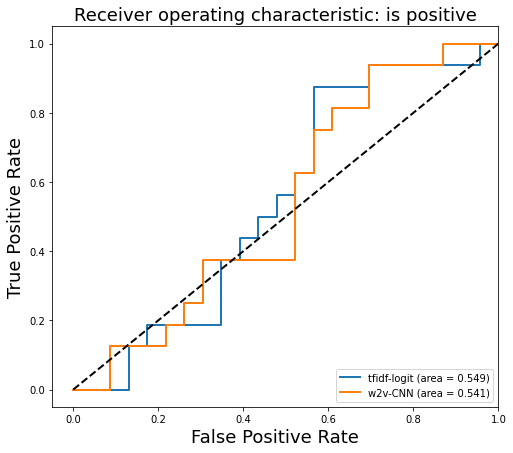

In [52]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, threshold = roc_curve(y_test, yhat_lr[:,1])
roc_auc = auc(fpr, tpr)
fpr_cnn, tpr_cnn, threshold = roc_curve(y_test, yhat_cnn)
roc_auc_nn = auc(fpr_cnn, tpr_cnn)
plt.figure(figsize=(8,7))
plt.plot(fpr, tpr, label='tfidf-logit (area = %0.3f)' % roc_auc, linewidth=2)
plt.plot(fpr_cnn, tpr_cnn, label='w2v-CNN (area = %0.3f)' % roc_auc_nn, linewidth=2)

plt.plot([0, 1], [0, 1], 'k--', linewidth=2)
plt.xlim([-0.05, 1.0])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('Receiver operating characteristic: is positive', fontsize=18)
plt.legend(loc="lower right")
plt.show()